# Eigendistortions

**Run notebook online with Binder:**[![Binder](http://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/LabForComputationalVision/plenoptic/master?filepath=examples/02_Eigendistortions.ipynb)

**In this tutorial we will cover:**
- theory behind eigendistortions
- how to use the `plenoptic.synthesize.eigendistortion.Eigendistortion` object
- computing eigendistortions using a simple input and linear model
- computing extremal eigendistortions for different layers of ResNet18

## Introduction
How can we assess whether a model sees like we do?
One way is to test whether they "notice" image distortions the same way as us.
For a model, a noticeable distortion would be an image perturbation that elicits a change in its response.
If our goal is to create models with human-like vision, then an image distortion that is (not) noticeable to a
human should also (not) be noticeable to our models.
Eigendistortions provide a framework with which to compare models to human visual perception of distortions.

_Berardino, A., Laparra, V., Ballé, J. and Simoncelli, E., 2017.
Eigen-distortions of hierarchical representations.
In Advances in neural information processing systems (pp. 3530-3539)._

http://www.cns.nyu.edu/pub/lcv/berardino17c-final.pdf

http://www.cns.nyu.edu/~lcv/eigendistortions/

**See the last section of this notebook for more mathematical detail**


In [1]:
import matplotlib.pyplot as plt
import torch
from plenoptic.synthesize.eigendistortion import Eigendistortion
from torch import nn
from torchvision import models
import os.path as op
import plenoptic as po

## Example 1: Linear model, small 1D input "image"


### 1.1) Creating the model

The fundamental goal of computing eigendistortions is to understand how small changes (distortions) in inputs
affect model outputs.
Any model can be thought of as a black box mapping an input to an output, $f(x): x \in \mathbb{R}^n \mapsto y
\in \mathbb{R}^m$, i.e. a function takes as input an n-dimensional vector $x$ and outputs an m-dimensional vector $y$.

The simplest model that achieves this is linear,

\begin{align}
    y &= f(x) = Mx, && \text{$M\in \mathbb{R^{m\times n}}$}.
\end{align}

In this linear case, the Jacobian is fixed $J= \frac{\partial f}{\partial x}=M$ for all possible inputs $x$.
Can we _synthesize_ a distortion $\epsilon$ such that $f(x+\epsilon)$ is maximally/minimally perturbed from the
original $f(x)$? Yes! This would amount to finding the first and last eigenvectors of the Fisher information matrix,
i.e. $J^TJ v = \lambda v$.

**A few things to note:**
- Input image should always be a 4D tensor whose dimensions `torch.Size([batch=1, channel, height, width])`.
    - We don't allow for batch synthesis of eigendistortions so the batch dim should always = 1

We'll be working with the `Eigendistortion` object and its instance method, `synthesize()`.

Let's make a linear PyTorch model and compute eigendistortions for a given input.

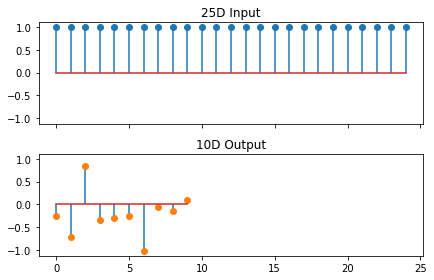

In [2]:
class LinearModel(nn.Module):
    """The simplest model we can make.
    Its Jacobian should be the weight matrix of M, and the eigenvectors of the Fisher matrix are therefore the
    eigenvectors of M.T @ M"""
    def __init__(self, n, m):
        super(LinearModel, self).__init__()
        torch.manual_seed(0)
        self.M = nn.Linear(n, m, bias=False)

    def forward(self, x):
        y = self.M(x)  # this computes y = x @ M.T
        return y

n = 25  # input vector dim (can you predict what the eigenvec/vals would be when n<m or n=m? Feel free to try!)
m = 10  # output vector dim

mdl_linear = LinearModel(n, m)

x0 = torch.ones((1, 1, 1, n))  # input must betorch.Size([batch=1, n_chan, img_height, img_width])
y0 = mdl_linear(x0)

fig, ax = plt.subplots(2, 1, sharex='all', sharey='all')
ax[0].stem(x0.squeeze(), use_line_collection=True)
ax[0].set(title=f'{n:d}D Input')

ax[1].stem(y0.squeeze().detach(), use_line_collection=True, markerfmt='C1o')
ax[1].set(title=f'{m:d}D Output')
fig.tight_layout()

### 1.2 - Synthesizing eigendistortions of linear model

To compute the eigendistortions of this model, we can instantiate an `Eigendistortion` object with a 4D input image
with dims `torch.Size([batch=1, n_channels, img_height, img_width])`, and any PyTorch model with valid
`forward` and `backward` methods. After that, we simply call the instance method `synthesize()` and choose the
appropriate synthesis method. Normally our input has thousands of entries, but our input in this case is small (only
n=25 entries), so we can compute the full $m \times n$ Jacobian, and all the eigenvectors of the
$n \times n$ Fisher matrix, $F=J^TJ$. The `synthesize` method does this for us and stores the outputs
(eigendistortions, eigenvalues, eigenindex) of the synthesis. These return values point to `synthesized_signal`,
`synthesized_eigenvalues`, `synthesized_eigenindex` attributes of the object, respectively.

In [3]:
help(Eigendistortion.synthesize)  # fully documented

eig_jac = Eigendistortion(base_signal=x0, model=mdl_linear)  # instantiate Eigendistortion object using an input and model
eigdist_jac, eigval_jac, eigind_jac = eig_jac.synthesize(method='exact')  # compute the entire Jacobian exactly

Help on function synthesize in module plenoptic.synthesize.eigendistortion:

synthesize(self, method: str = 'power', k: int = 1, max_steps: int = 1000, p: int = 5, q: int = 2, tol: float = 1e-07, seed: int = None) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]
    Compute eigendistortions of Fisher Information Matrix with given input image.
    
    Parameters
    ----------
    method: {'exact', 'power', 'randomized_svd'}, optional
        Eigensolver method. Jacobian tries to do eigendecomposition directly (
        not recommended for very large inputs). 'power' (default) uses the power method to compute first and
        last eigendistortions, with maximum number of iterations dictated by n_steps. 'randomized_svd' uses
        randomized SVD to approximate the top k eigendistortions and their corresponding eigenvalues.
    k: int
        How many vectors to return using block power method or svd.
    max_steps: int, optional
        Maximum number of steps to run for ``method='

### 1.3 - Comparing our synthesis to ground-truth

The Jacobian is in general a rectangular (not necessarily square) matrix $J\in \mathbb{R}^{m\times n}$. Since this is
a linear model, let's check if the computed Jacobian (stored as an attribute in the `Eigendistortion` object) matches
the weight matrix $M$.

Since the eigendistortions are each 1D (vectors) in this example, we can display them all as an image where each
column is an eigendistortion, each pixel is an entry of the eigendistortion, and the intensity is proportional to its
value.

Jacobian == weight matrix M?: True


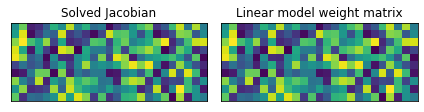

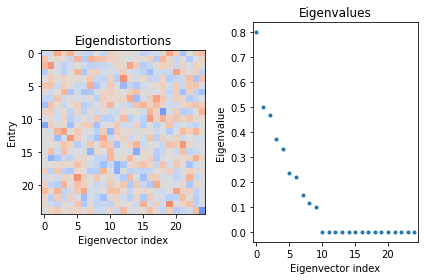

In [4]:
fig, ax = plt.subplots(1, 2, sharex='all', sharey='all')
ax[0].imshow(eig_jac.jacobian)
ax[1].imshow(mdl_linear.M.weight.data, vmin=eig_jac.jacobian.min(), vmax=eig_jac.jacobian.max())
ax[0].set(xticks=[], yticks=[], title='Solved Jacobian')
ax[1].set(title='Linear model weight matrix')
fig.tight_layout()

print("Jacobian == weight matrix M?:", eig_jac.jacobian.allclose(mdl_linear.M.weight.data))

# Eigenvectors (aka eigendistortions) and associated eigenvectors are found in the distortions dict attribute
fig, ax = plt.subplots(1, 2, sharex='all')
ax[0].imshow(eigdist_jac.squeeze(), vmin=-1, vmax=1, cmap='coolwarm')
ax[0].set(title='Eigendistortions', xlabel='Eigenvector index', ylabel='Entry')
ax[1].plot(eigval_jac, '.')
ax[1].set(title='Eigenvalues', xlabel='Eigenvector index', ylabel='Eigenvalue')
fig.tight_layout()

### 1.4 - What do these eigendistortions _mean_?

The first eigenvector (with the largest eigenvalue) is the direction in which we can distort our input $x$ and change
the response of the model the _most_, i.e. its most noticeable distortion. For the last eigenvector, since its
associated eigenvalue is 0, then _no change in response occurs_ when we distort the input in that direction, i.e.
$f(x+\epsilon)=f(x)$. So this distortion would be _imperceptible_ to the model.

In most cases, our input would be much larger. An $n\times n$ image has $n^2$ entries, meaning the Fisher
matrix is $n^2 \times n^2$, and therefore $n^2$ possible eigendistortions -- certainly too large to store in memory. We
need to instead resort to numerical methods to compute the eigendistortions. To do this, we can just set our
synthesis `method='power'` to estimate the first eigenvector (most noticeable distortion) and last eigenvector
(least noticeable distortion) for the image.


Initializing Eigendistortion -- Input dim: 25 | Output dim: 10


Top k=1 eigendists computed | Tolerance 1.00E-07 reached.



Bottom k=1 eigendists computed | Tolerance 1.00E-07 reached.

Indices of computed eigenvectors: tensor([ 0, 24])

Are the first eigendistortions the same? True
Are the last eigendistortions the same? False


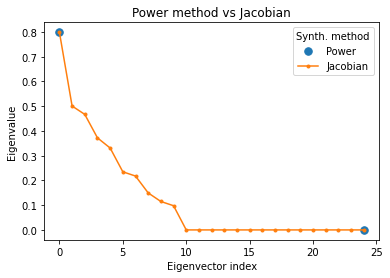

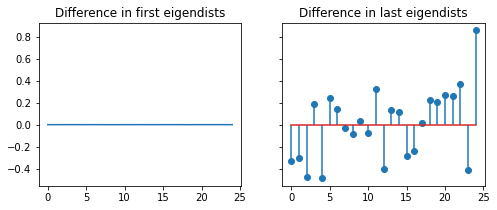

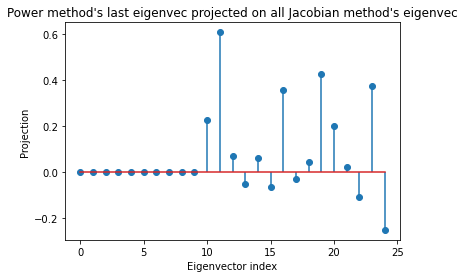

In [5]:
eig_pow = Eigendistortion(x0, mdl_linear)
eigdist_pow, eigval_pow, eigind_pow  = eig_pow.synthesize(method='power', max_steps=1000)
eigdist_pow = eigdist_pow.squeeze()  # squeeze out singleton channel dimension (these are grayscale)
eigdist_jac = eigdist_jac.squeeze()

print(f'Indices of computed eigenvectors: {eigind_pow}\n')

fig, ax = plt.subplots(1,1)
ax.plot(eigind_pow, eigval_pow, '.', markersize=15, label='Power')
ax.plot(eig_jac.synthesized_eigenvalues, '.-', label='Jacobian')
ax.set(title='Power method vs Jacobian', xlabel='Eigenvector index', ylabel='Eigenvalue')
ax.legend(title='Synth. method')

fig, ax = plt.subplots(1, 2, sharex='all', sharey='all', figsize=(8,3))
ax[0].plot(eigdist_pow[0] - eigdist_jac[0])
ax[0].set(title='Difference in first eigendists')

ax[1].stem(eigdist_pow[-1] - eigdist_jac[-1], use_line_collection=True)
ax[1].set(title='Difference in last eigendists')

fig, ax = plt.subplots(1,1)
ax.stem(eigdist_jac @ eigdist_pow[-1] , use_line_collection=True)
ax.set(title="Power method's last eigenvec projected on all Jacobian method's eigenvec",
       xlabel='Eigenvector index', ylabel='Projection')

print('Are the first eigendistortions the same?', eigdist_pow[0].allclose(eigdist_jac[0], atol=1e-3))
print('Are the last eigendistortions the same?', eigdist_pow[-1].allclose(eigdist_jac[-1], atol=1e-3))

# find eigendistortions of Jacobian-method whose eigenvalues are zero
ind_zero = eig_jac.synthesized_eigenvalues.isclose(torch.zeros(1), atol=1e-4)

The power method's first eigendistortion matches the ground-truth first eigendistortion obtained via the Jacobian
solve. And while the last eigendistortions don't match, the last power method eigendistortion lies in the span of all
the eigendistortions whose eigenvalues are zero. Each of these eigendistortions whose eigenvalues are zero are
equivalent. Any distortion of $x$ in the span of these eigendistortions would result in _no change_ in the model
output, and would therefore be imperceptible to the model.

### 1.5 - The Fisher information matrix is a locally adaptive
Different inputs should in general have different sets of eigendistortions -- a noticible distortion in one image
would not necessarily be noticeable in a different image. The only case where they should be the same regardless of
input is when the model is fully linear, as in this simple example. So let's check if the Jacobian at a different
input still equals the weight matrix $M$.

In [6]:
x1 = torch.randn_like(x0)  # generate some random input
eig_jac2 = Eigendistortion(x1, model=mdl_linear)
eig_jac2.synthesize(method='exact')  # since the model is linear, the Jacobian should be the exact same as before

print(f'Does the jacobian at x1 still equal the model weight matrix?'
      f' {eig_jac2.jacobian.allclose(mdl_linear.M.weight.data)}')


Initializing Eigendistortion -- Input dim: 25 | Output dim: 10
Computing all eigendistortions
Does the jacobian at x1 still equal the model weight matrix? True


## Example 2: Which layer of ResNet is a better model of human visual distortion perception?

Now that we understand what eigendistortions are and how the `Eigendistortion` class works, let's compute them real
images using a more complex model like Vgg16. The response vector $y$ doesn't necessarily have to be the output of the
last layer of the model; we can also compute Eigendistortions for intermediate model layers too. Let's synthesize
distortions for an image using different layers of Vgg16 to see which layer produces extremal eigendistortions that
align more with human perception.

### 2.1 - Load an example an image

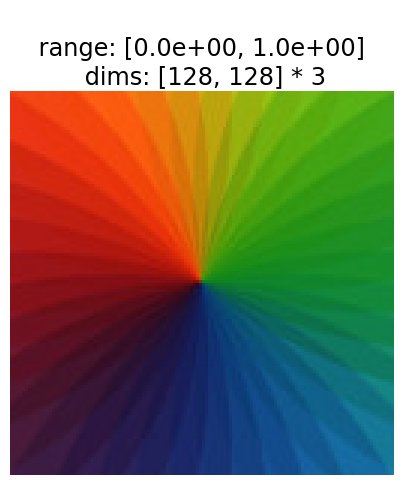

In [7]:
# a couple helper functions

def center_crop(im, n):
    """Crop an nxn image from the center of im"""
    im_height, im_width = im.shape[:2]
    assert n<im_height and n<im_width

    im_crop = im[im_height//2-n//2:im_height//2+n//2,
              im_width//2-n//2:im_width//2+n//2]
    return im_crop

n = 128  # this will be the img_height and width of the input, you can change this to accommodate your machine
img = plt.imread(op.join('../data', 'color_wheel.jpg')).copy()

# center crop the image to nxn
img = center_crop(img, n)

img = po.tools.rescale(img)  # rescale to [0, 1]

img3 = torch.as_tensor(img, dtype=torch.float).unsqueeze(0).permute((0,3,1,2)) # permute to (b, c, h, w)
po.imshow(img3, as_rgb=True, zoom=3);

### 2.2 - Instantiate models and Eigendistortion objects
Let's make a wrapper class that can return the nth layer output of vgg. We're going to use this to compare
eigendistortions synthesized using different layers of Vgg as models for distortion perception.

In [8]:
# Create a class that takes the nth layer output of a given model
class NthLayer(torch.nn.Module):
    """Wrap any model to get the response of an intermediate layer
    
    Works for Resnet18 or VGG16.
    
    """
    def __init__(self, model, layer=None):
        """
        Parameters
        ----------
        model: PyTorch model
        layer: int
            Which model response layer to output
        """
        super().__init__()
        try:
            # then this is VGG16
            features = list(model.features)
        except AttributeError:
            # then it's resnet18
            features = ([model.conv1, model.bn1, model.relu, model.maxpool] + [l for l in model.layer1] + 
                        [l for l in model.layer2] + [l for l in model.layer3] + [l for l in model.layer4] + 
                        [model.avgpool, model.fc])
        self.features = nn.ModuleList(features).eval()

        if layer is None:
            layer = len(self.features)
        self.layer = layer

    def forward(self, x):
        for ii, mdl in enumerate(self.features):
            x = mdl(x)
            if ii == self.layer:
                return x

# different potential models of human visual perception of distortions
resnet18_a = NthLayer(models.resnet18(pretrained=True), layer=3)
resnet18_b = NthLayer(models.resnet18(pretrained=True), layer=6)

ed_resneta = Eigendistortion(img3, resnet18_a)
ed_resnetb = Eigendistortion(img3, resnet18_b)


Initializing Eigendistortion -- Input dim: 49152 | Output dim: 65536

Initializing Eigendistortion -- Input dim: 49152 | Output dim: 32768


### 2.3 - Synthesizing distortions
The input dimensionality in this example is huge compared to our linear model example -- it is $(\text{n_chan} \times
\text{img_height} \times \text{img_width})^2$, meaning the Fisher matrix is too massive to compute exactly. We must
turn to iterative methods. Let's synthesize the extremal eigendistortions for this picture of Einstein using the
different layers of ResNet as defined above.

In [9]:
# Bump up n_steps if you wish
ed_resneta.synthesize(method='power', max_steps=400)
ed_resnetb.synthesize(method='power', max_steps=400);

Top k=1 eigendists computed | Tolerance 1.00E-07 reached.



Top k=1 eigendists computed | Tolerance 1.00E-07 reached.



### 2.4 - Visualizing eigendistortions
Let's display the eigendistortions. `Eigendistortion` has an instance method `display` that will display a 2x3
subplot figure of images. The top row shows the original image on the left, the synthesized maximal eigendistortion
on the right, and some constsant $\alpha$ times the eigendistortion added to the image in the middle panel. The
bottow row has a similar layout, but displays the minimal eigendistortion. Let's display the eigendistortions for
both models.


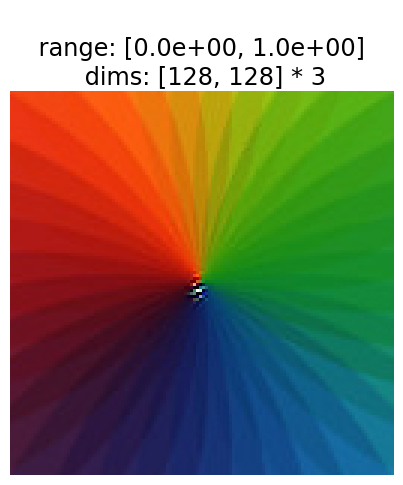

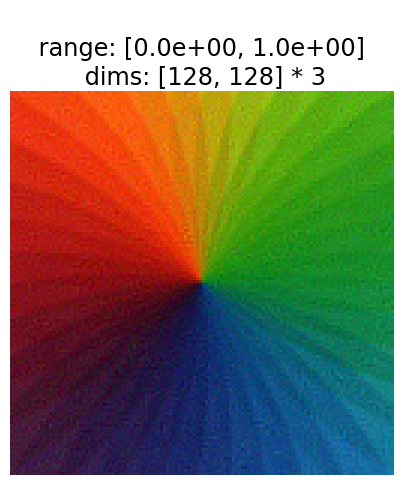

In [10]:
ed_resneta.plot_distorted_image(0, as_rgb=True, zoom=3);
ed_resneta.plot_distorted_image(-1, as_rgb=True, zoom=3);

### 2.5 - Which synthesized extremal eigendistortions better characterize human perception?

Let's compare eigendistortions within a model first. One thing we immediately notice is that the first
eigendistortion (labeled `maxdist`) is indeed more noticeable than `mindist`. `maxdist` is localized to a single
portion of the image, and has lower, more prominent spatial frequency content than `mindist`. `mindist` looks more
like high frequency noise distributed across the image.

But how do the distortions compare between models -- which model better characterizes human visual perception of
distortions? The only way to truly this is to run an experiment and ask human observers which distortions are
most/least noticeable to them. The best model should produce a maximally noticeable distortion that is more
noticeable than other models' maximally noticeable distortions, and its minimally noticeable distortion should be
less noticeable than other models' minimally noticeable distortions.

See Berardino et al. 2017 for more details.

### 2.6 - Synthesizing distortions for other images

Remember the Fisher matrix is locally adaptive, meaning that a different image should have a different set of
eigendistortions. Let's finish off this notebook with another set of extremal eigendistortions for these two
Vgg16 layers on a different image.


Initializing Eigendistortion -- Input dim: 49152 | Output dim: 65536

Initializing Eigendistortion -- Input dim: 49152 | Output dim: 32768


Top k=1 eigendists computed | Tolerance 1.00E-07 reached.



Top k=1 eigendists computed | Tolerance 1.00E-07 reached.



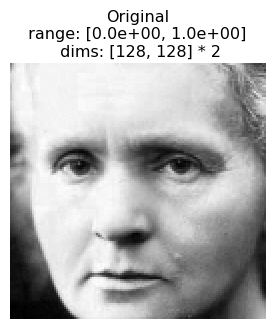

In [12]:
img = plt.imread(op.join('../data', '256/curie.pgm')).copy()

# center crop the image to nxn
img = center_crop(img, n)

img = po.tools.rescale(img)  # rescale to [0, 1]

img = torch.tensor(img, dtype=torch.float).reshape(1, 1, *img.shape)
img3 = torch.repeat_interleave(img, 3, dim=1)

ed_resneta = Eigendistortion(img3, resnet18_a)
ed_resnetb = Eigendistortion(img3, resnet18_b)

ed_resneta.synthesize(method='power', max_steps=400)
ed_resnetb.synthesize(method='power', max_steps=400)

po.imshow(img, zoom=2, title="Original");

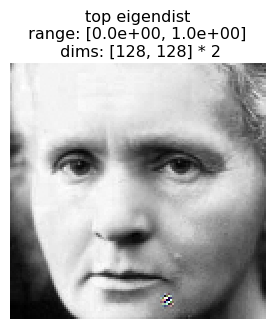

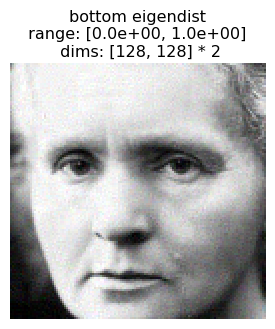

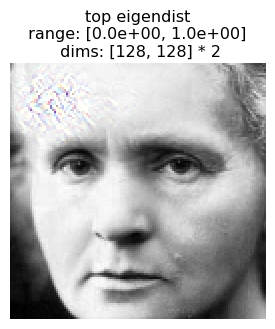

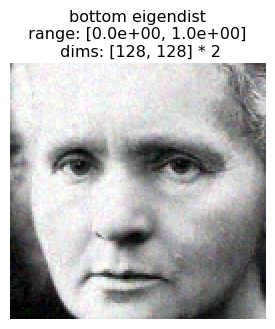

In [13]:
ed_resneta.plot_distorted_image(0, as_rgb=True, zoom=2, title="top eigendist");
ed_resneta.plot_distorted_image(-1, as_rgb=True, zoom=2, title="bottom eigendist");

ed_resnetb.plot_distorted_image(0, as_rgb=True, zoom=2, title="top eigendist");
ed_resnetb.plot_distorted_image(-1, as_rgb=True, zoom=2, title="bottom eigendist");

## Appendix: More mathematical detail

If we have a model that takes an N-dimensional input and outputs an M-dimensional response, then its Jacobian,
$J=\frac{\partial f}{\partial x}$, is an $M\times N$ matrix of partial derivatives that tells us how much a change in
each entry of the input would change each entry of the output. With the assumption of additive Gaussian noise in the
output space Fisher Information Matrix, $F$, is a symmetric positive semi-definite, $N\times N$ matrix computed using
the Jacobian, $F=J^TJ$. If you are familiar with linear algebra, you might notice that  the eigenvectors of $F$ are
the right singular vectors of the Jacobian. Thus, an eigendecomposition $F=V\Lambda V$ yields directions of the
_input space_ (vectors in $V$) along which changes in the _output space_ are rank-ordered by entries in diagonal
matrix $\Lambda$.

Given some input image $x_0$, an **eigendistortion** is an additive perturbation, $\epsilon$, in the _input domain_
that changes the response in a model's _output domain_ of interest (e.g. an intermediate layer of a neural net, the
output of a nonlinear model, etc.).
These perturbations are named _eigendistortions_ because they push $x_0$ along eigenvectors of the Fisher Information Matrix.
So we expect distortions $x_0$ along the direction of the eigenvector with the maximum eigenvalue will change the
representation the _most_, and distortions along the eigenvector with the minimum eigenvalue will change the
representation  the _least_. (And pushing along intermediate eigenvectors will change the representation by an
intermediate amount.)